# Milestone Project 2: SkimLit

Purpose: Create an NLP model to classify abstracts of medical papers into different categories

Model Architecture: Available https://arxiv.org/abs/1612.05251

# Get Data

We can do so from author's Github repository: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [3]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt   test.txt  train.txt


In [4]:
!bat pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt | head -n 5

###24845963
BACKGROUND	This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .
RESULTS	A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .
RESULTS	Liver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .
RESULTS	Survival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .


In [5]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [7]:
# Prepare data to be used with Model
# Visualize the data

def get_lines(filename):
    """
    Reads filename and returns the lines of text as a list
    """
    with open(filename, "r") as f:
        return f.readlines()

In [8]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

# Think about how we want the data to look

```python
[{'line_number' : 0,
   'target' : 'BACKGROUND',
   'text': 'some text',
   'total_lines': 11}, ...next abstract]
```

In [10]:
def preprocess_test_with_line_number(filename):
    """
    Returns a list of dictionaries of abstract line data

    Takes in filename, reads its contents and sorts through each line,
    extracting things like the label, the text of the sentence, and the line number.
    """

    input_lines = get_lines(filename)
    abstract_lines=""
    abstract_samples = []
    for line in input_lines:
        if line.startswith("###"): # Check to see if the line is an ID line
            abstract_id = line
            abstract_lines = ""
        elif line.isspace(): # Check to see if the line is a new line
            abstract_line_split = abstract_lines.splitlines()
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1]
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split) - 1 # start from 0
                abstract_samples.append(line_data)
        else:
            abstract_lines += line
    return abstract_samples



In [11]:
# Get data from file and preprocess it
import time
time_start = time.perf_counter()
train_samples = preprocess_test_with_line_number(data_dir + "train.txt")
val_samples = preprocess_test_with_line_number(data_dir + "dev.txt") # dev == validation set
test_samples = preprocess_test_with_line_number(data_dir + "test.txt")
time_end = time.perf_counter()
print(f"Time taken to preprocess data: {time_end - time_start:.2f} seconds")
print(len(train_samples), len(val_samples), len(test_samples))

Time taken to preprocess data: 0.18 seconds
180040 30212 30135


In [12]:
# Check the first abstract of the training data
train_samples[:11]

[{'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Secondary outcome measures included the Western Ontari

In [13]:
import pandas as pd 
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,11
6,RESULTS,There was a clinically relevant reduction in t...,6,11
7,RESULTS,The mean difference between treatment arms ( @...,7,11
8,RESULTS,"Further , there was a clinically relevant redu...",8,11
9,RESULTS,These differences remained significant at @ we...,9,11


In [14]:
# Distribution of Labels
train_df["target"].value_counts()


target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

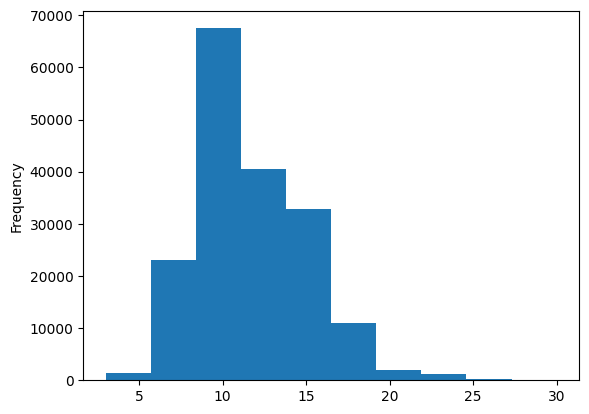

In [15]:
# Length of different lines
train_df.total_lines.plot.hist()

### Get list of sentences

In [16]:
# convert text lines into lists
train_setences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_setences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
# View the first 10 lines of training sentences
train_setences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

<Axes: ylabel='Frequency'>

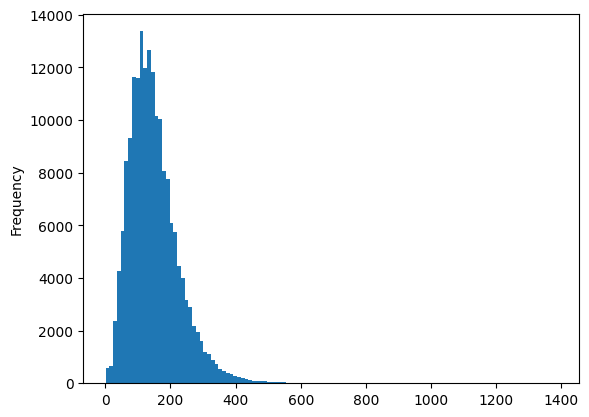

In [18]:
num_bins = len(set([len(sentence.split()) for sentence in train_setences]))
train_df["text"].str.len().plot.hist(bins=120)

<Axes: ylabel='Frequency'>

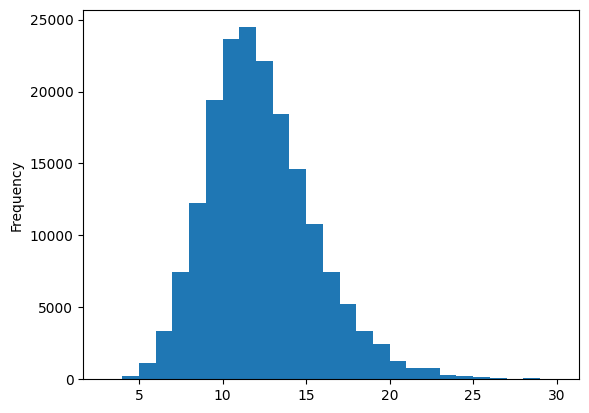

In [19]:
# Number of sentences per abstract
num_bins = len(train_df["total_lines"].unique())
train_df["total_lines"].plot.hist(bins=num_bins)

## Make numeric labels (ML models require numeric labels)

In [20]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
# check what one hot encoded labels look like
train_labels_one_hot
val_labels_one_hot
test_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [21]:
import tensorflow as tf
tf.constant(train_labels_one_hot), tf.constant(val_labels_one_hot), tf.constant(test_labels_one_hot)

(<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
 array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])>,
 <tf.Tensor: shape=(30212, 5), dtype=float64, numpy=
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])>,
 <tf.Tensor: shape=(30135, 5), dtype=float64, numpy=
 array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]])>)

# Label encode labels

In [22]:
# Extract Labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [23]:
# Get class
num_classes = len(label_encoder.classes_)
classes = label_encoder.classes_
print(f"Classes: {classes}")
print(f"Number of classes: {num_classes}")

Classes: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']
Number of classes: 5


# Baseline Model

 https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

## Model 0: Getting Baseline

In [24]:
# TF-IDF Naive Bayes classifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_setences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
# Evaluate the model
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [26]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [27]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-18 15:06:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-05-18 15:06:42 (17.0 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



In [28]:
from helper_functions import calculate_results
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded, y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [29]:
# Tokenize text
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

In [30]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_setences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

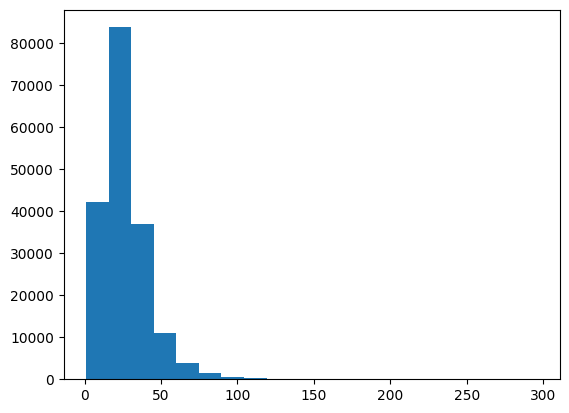

In [31]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [32]:
# How long of a sentence length covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [33]:
# Max sentence length in the training set
max(sent_lens)

296

### Create text vectorizer layers
Convert text into numbers

In [34]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=68_000, # taken from paper; number of words in the vocabulary
    output_sequence_length=output_seq_len,
)


In [35]:
# Adapt text vectorization layer to training sentences
vectorize_layer.adapt(train_setences)

In [36]:
# Test out the vectorizer
import random 
target_sentence = random.choice(train_setences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
vectorized_sentence = vectorize_layer([target_sentence])
print(f"\nVectorized text:\n{vectorized_sentence}")
print(f"\nLength of vectorized text: {len(vectorized_sentence[0])}")


Text:
Benzodiazepines are considered first-line therapy for pediatric status epilepticus .

Length of text: 10

Vectorized text:
[[9227   58  535 1368   66   11 1018  272 9182    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Length of vectorized text: 55


In [37]:
# How many words in our training vocabulary
rct_20k_text_vocab = vectorize_layer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}")

Number of words in vocabulary: 64841


In [38]:
# Most common words in the vocabulary
most_common_words = rct_20k_text_vocab[:20]
least_common_words = rct_20k_text_vocab[-20:]
print(f"Most common words in vocab: {most_common_words}")
print(f"Least common words in vocab: {least_common_words}")

Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were', 'was', 'for', 'patients', 'group', 'p', 'at', 'or', 'study', 'on', 'treatment']
Least common words in vocab: ['abandon', 'abaloparatideinduced', 'abagovomabinduced', 'abacus', 'abacopd', 'abacavirlamivudinezidovudine', 'ababa', 'aavsercaa', 'aats', 'aartselaar', 'aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [39]:
# Get the config of our TextVectorization layer
vectorize_layer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'float32',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [40]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), output_dim=128, mask_zero=True, name="token_embedding")


In [41]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = vectorize_layer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")

Sentence before vectorization:
Benzodiazepines are considered first-line therapy for pediatric status epilepticus .

Sentence after vectorization (before embedding):
[[9227   58  535 1368   66   11 1018  272 9182    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.0434663  -0.03763174 -0.01744611 ...  0.00885121 -0.0012434
    0.03655782]
  [ 0.03491265  0.02338877 -0.00217951 ...  0.01692596 -0.01017623
    0.02200384]
  [-0.00787042 -0.0294723  -0.0394761  ...  0.02734346 -0.01736994
    0.00087268]
  ...
  [-0.02840441  0.03579743 -0.03635225 ... -0.03123637 -0.04682988
    0.0453727 ]
  [-0.02840441  0.03579743 -0.03635225 ... -0.03123637 -0.04682988
    0.0453727 ]
  [-0.02840441  0.03579743 -0.03635225 ... -0.03123637 -0.04682988
    0.0453727 ]]]



In [42]:
# Create datasets (making sure our data loads as fast as possible)
train_dataset = tf.data.Dataset.from_tensor_slices((train_setences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [43]:
# Prefetch and batch the datasets
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
model_1 = tf.keras.Sequential([
    vectorize_layer,
    token_embed,
    layers.Conv1D(32, kernel_size=5, padding="same", activation="relu"),
    layers.Conv1D(64, kernel_size=5, padding="same", activation="relu"),
    layers.GlobalAveragePooling1D(),
    layers.Dense(num_classes, activation="softmax")
], name="model_1_conv1D")

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
history_model_1 = model_1.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            epochs=3, 
            validation_data=valid_dataset,
            validation_steps=int(0.1*len(valid_dataset)),
            callbacks=[])

Epoch 1/3


/Users/calwetzel/.pyenv/versions/3.11.7/envs/DLplayground/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5243 - loss: 1.1380 - val_accuracy: 0.7350 - val_loss: 0.6988
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7381 - loss: 0.6933 - val_accuracy: 0.7480 - val_loss: 0.6550
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7620 - loss: 0.6346 - val_accuracy: 0.7859 - val_loss: 0.5954


In [45]:
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7837 - loss: 0.5968


[0.6015878915786743, 0.7826029658317566]

In [46]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[4.5865721e-01, 1.3980910e-01, 1.1874450e-01, 2.6613730e-01,
        1.6651841e-02],
       [4.3752116e-01, 2.7283075e-01, 1.2980278e-02, 2.7088630e-01,
        5.7814624e-03],
       [1.6190787e-01, 4.0433072e-03, 7.7932217e-04, 8.3326483e-01,
        4.7156677e-06],
       ...,
       [9.3149256e-06, 2.7353258e-03, 9.9498983e-03, 6.8464351e-06,
        9.8729855e-01],
       [5.4914173e-02, 4.9297825e-01, 7.0059538e-02, 4.3931965e-02,
        3.3811617e-01],
       [1.7483391e-01, 6.6167605e-01, 2.1868121e-02, 5.9882481e-02,
        8.1739463e-02]], dtype=float32)

In [47]:
# Convert pred probs to classes
mode_1_preds = tf.argmax(model_1_pred_probs, axis=1)
# Classes names
class_predictions = [classes[i] for i in mode_1_preds]
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded, y_pred=mode_1_preds)
model_1_results

{'accuracy': 78.26029392294453,
 'precision': 0.7804591950654083,
 'recall': 0.7826029392294452,
 'f1': 0.7806847021150289}

## Model 2: Feature extraction with pretrained token embeddings

In [48]:
# Use pretrained word embeddings -- USE  
# https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")


In [49]:
import random
random_train_sentence = random.choice(train_setences)
print(f"Random sentence:\n{random_train_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence}\n")
print(f"Sentence after embedding shape:\n{use_embedded_sentence[0].shape}")

Random sentence:
Internal consistency of the measure was strong for sessions @ and @ and poor for session @ .

Sentence after embedding:
[[ 1.62205438e-03 -4.21949215e-02 -8.04080963e-02  5.44337109e-02
   4.64698374e-02  3.33409272e-02 -1.90633517e-02 -2.63054203e-02
   1.70153547e-02  2.61765625e-02 -4.23691282e-03  5.48986904e-02
  -2.86165290e-02 -8.14308412e-03 -4.33974266e-02  3.32513936e-02
  -5.48296273e-02  4.09216471e-02  2.58894823e-02 -6.60477031e-04
  -9.89027414e-03  7.48954639e-02  3.41223627e-02 -4.18184176e-02
  -1.53079582e-02  1.72475521e-02  1.20289428e-02 -2.17703450e-03
   6.25724904e-04  2.62116399e-02  4.77263033e-02 -2.21891943e-02
   6.39836416e-02 -1.33160474e-02 -4.20110449e-02 -4.36702147e-02
   5.23317233e-03 -5.41639328e-02 -1.10079106e-02  4.49921750e-03
  -6.06845506e-02  3.75815146e-02 -3.76305394e-02  1.14120329e-02
   3.10816299e-02  5.09921201e-02  2.34588701e-02  3.66361551e-02
   4.51993421e-02  1.50946854e-02  4.39426862e-02 -1.17055895e-02
  -9.

In [50]:
class MyLayer(layers.Layer):
    def call(self, inputs):
        return tf_hub_embedding_layer(inputs)

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = MyLayer()(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name="model_2_USE")

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
history_model_2 = model_2.fit(train_dataset,
                                epochs=3,
                                steps_per_epoch=int(0.1*len(train_dataset)),
                                validation_data=valid_dataset,
                                validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5819 - loss: 1.0998 - val_accuracy: 0.6918 - val_loss: 0.7972
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7039 - loss: 0.7711 - val_accuracy: 0.7111 - val_loss: 0.7564
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7134 - loss: 0.7550 - val_accuracy: 0.7201 - val_loss: 0.7286


In [51]:
model_2.summary()

Model: "model_2_USE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_layer (MyLayer)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,929 (777.07 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 132,620 (518.05 KB)

In [52]:
model_2.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7135 - loss: 0.7395


[0.7405833601951599, 0.713689923286438]

In [53]:
# make predictions with model_2
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


array([[4.1058367e-01, 3.7852171e-01, 3.1570797e-03, 1.9974783e-01,
        7.9897735e-03],
       [3.3069429e-01, 5.1483750e-01, 3.7710380e-03, 1.4724028e-01,
        3.4567998e-03],
       [2.4272454e-01, 1.5609820e-01, 2.2219524e-02, 5.3954291e-01,
        3.9414801e-02],
       ...,
       [1.9748777e-03, 6.3824654e-03, 4.6391111e-02, 9.4372925e-04,
        9.4430774e-01],
       [4.4812178e-03, 5.1739745e-02, 2.0710705e-01, 1.7232903e-03,
        7.3494875e-01],
       [1.7716405e-01, 2.6122138e-01, 4.8217407e-01, 7.0533534e-03,
        7.2387226e-02]], dtype=float32)

In [54]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_results = calculate_results(y_true=val_labels_encoded, y_pred=model_2_preds)
model_2_results

{'accuracy': 71.36899245332981,
 'precision': 0.7136924627020148,
 'recall': 0.713689924533298,
 'f1': 0.710679900774695}

In [55]:
baseline_results, model_1_results, model_2_results

({'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294},
 {'accuracy': 78.26029392294453,
  'precision': 0.7804591950654083,
  'recall': 0.7826029392294452,
  'f1': 0.7806847021150289},
 {'accuracy': 71.36899245332981,
  'precision': 0.7136924627020148,
  'recall': 0.713689924533298,
  'f1': 0.710679900774695})

## Model 3: Conv1D with character embeddings

### Creating a character-level tokenizer 

In [56]:
train_setences[:5]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .']

In [57]:
def split_chars(text):
    return " ".join(list(text))

In [58]:
split_chars(train_setences[0])

'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .'

In [59]:
train_chars = [split_chars(sentence) for sentence in train_setences]

In [60]:
train_chars[:5]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .',
 'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [61]:
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [62]:
# Average char length
char_lens = [len(sentence) for sentence in train_setences]
avg_char_len = np.mean(char_lens)
avg_char_len

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <BarContainer object of 20 artists>)

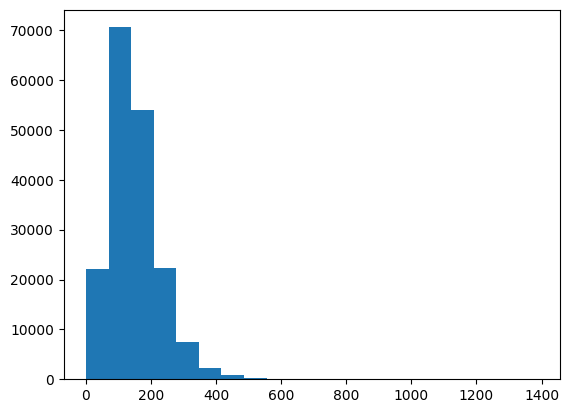

In [63]:
plt.hist(char_lens, bins=20)

In [64]:
# What char length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [65]:
# Get all keyboard chars
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS, output_sequence_length=output_seq_char_len, name="char_vectorizer")
char_vectorizer.adapt(train_chars)


In [67]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in the vocabulary: {len(char_vocab)}")
print(f"Most common characters in the vocabulary: {char_vocab[:5]}")
print(f"Least common characters in the vocabulary: {char_vocab[-5:]}")

Number of different characters in the vocabulary: 28
Most common characters in the vocabulary: ['', '[UNK]', 'e', 't', 'i']
Least common characters in the vocabulary: ['k', 'x', 'z', 'q', 'j']


In [68]:
#NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
#char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS, standardize=None, output_sequence_length=output_seq_char_len, name="char_vectorizer")
#char_vectorizer.adapt(train_chars)

In [69]:
#char_vocab = char_vectorizer.get_vocabulary()
#print(f"Number of different characters in the vocabulary: {len(char_vocab)}")
#print(f"Most common characters in the vocabulary: {char_vocab[:5]}")
#print(f"Least common characters in the vocabulary: {char_vocab[-5:]}")

In [70]:
random_train_chars = random.choice(train_chars)
print(f"Random characters:\n{random_train_chars}\n")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized characters:\n{vectorized_chars}\n")
print(f"Length of vectorized characters: {len(vectorized_chars[0])}")


Random characters:
T h o s e   r a n d o m i z e d   t o   t h e   i n t e r v e n t i o n   g r o u p   w e r e   t r a n s p o r t e d   t o   s e v e r a l   a l t e r n a t i v e   d e s t i n a t i o n s   d e c i d e d   b y   a   t r a i n e d   n u r s e   p e r f o r m i n g   a   c o m p r e h e n s i v e   a s s e s s m e n t   ,   u s i n g   t h e   n e w   p r e h o s p i t a l   s y s t e m   .

Vectorized characters:
[[ 3 13  7  9  2  8  5  6 10  7 15  4 25  2 10  3  7  3 13  2  4  6  3  2
   8 21  2  6  3  4  7  6 18  8  7 16 14 20  2  8  2  3  8  5  6  9 14  7
   8  3  2 10  3  7  9  2 21  2  8  5 12  5 12  3  2  8  6  5  3  4 21  2
  10  2  9  3  4  6  5  3  4  7  6  9 10  2 11  4 10  2 10 22 19  5  3  8
   5  4  6  2 10  6 16  8  9  2 14  2  8 17  7  8 15  4  6 18  5 11  7 15
  14  8  2 13  2  6  9  4 21  2  5  9  9  2  9  9 15  2  6  3 16  9  4  6
  18  3 13  2  6  2 20 14  8  2 13  7  9 14  4  3  5 12  9 19  9  3  2 15
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  

## Creating a character level embedding

In [71]:
char_emed = layers.Embedding(input_dim=len(char_vocab), output_dim=25, # 25 is the output_dim from the paper
                             mask_zero=True, name="char_embed")

In [72]:
# Test out character embedding layer
print(f"Charified text:\n{random_train_chars}\n")
char_embed_example = char_vectorizer([random_train_chars])
print(f"Embedded chars:\n{char_emed(char_embed_example)}\n")
print(f"Embedded chars shape:\n{char_emed(char_embed_example).shape}")


Charified text:
T h o s e   r a n d o m i z e d   t o   t h e   i n t e r v e n t i o n   g r o u p   w e r e   t r a n s p o r t e d   t o   s e v e r a l   a l t e r n a t i v e   d e s t i n a t i o n s   d e c i d e d   b y   a   t r a i n e d   n u r s e   p e r f o r m i n g   a   c o m p r e h e n s i v e   a s s e s s m e n t   ,   u s i n g   t h e   n e w   p r e h o s p i t a l   s y s t e m   .

Embedded chars:
[[[ 0.00810029 -0.00273986 -0.04541907 ...  0.0369407  -0.03450833
    0.01727283]
  [-0.02948164  0.02562675  0.00397315 ... -0.01206506  0.01044544
   -0.00809815]
  [-0.02236762  0.01929912 -0.0137373  ... -0.00399482  0.01600227
   -0.0048807 ]
  ...
  [ 0.03198931  0.01443097  0.03560031 ... -0.03243301 -0.038315
    0.04510963]
  [ 0.03198931  0.01443097  0.03560031 ... -0.03243301 -0.038315
    0.04510963]
  [ 0.03198931  0.01443097  0.03560031 ... -0.03243301 -0.038315
    0.04510963]]]

Embedded chars shape:
(1, 290, 25)


In [73]:
# Conv1D with character embeddings
inputs = layers.Input(shape=(1,), dtype="string") # 1 sequence at a time
char_vectors = char_vectorizer(inputs)
char_embeddings = char_emed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1D_char_embedding")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

/Users/calwetzel/.pyenv/versions/3.11.7/envs/DLplayground/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "model_3_conv1D_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embed (Embedding)          │ (None, 290, 25)        │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 290, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [75]:
history_model_3 = model_3.fit(train_char_dataset,
                                steps_per_epoch=int(0.1*len(train_char_dataset)),
                                epochs=3,
                                validation_data=valid_char_dataset,
                                validation_steps=int(0.1*len(valid_char_dataset)))


Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4195 - loss: 1.4029 - val_accuracy: 0.5805 - val_loss: 1.0408
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5899 - loss: 1.0264 - val_accuracy: 0.6297 - val_loss: 0.9384
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6307 - loss: 0.9390 - val_accuracy: 0.6473 - val_loss: 0.8975


In [76]:
# Make predictions with character model
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[0.17928469, 0.3774364 , 0.12168618, 0.27445891, 0.04713375],
       [0.13012399, 0.64323425, 0.02014665, 0.18186502, 0.02463017],
       [0.07310851, 0.23021612, 0.4092832 , 0.1883451 , 0.09904694],
       ...,
       [0.02474739, 0.04030166, 0.06923794, 0.03753274, 0.82818025],
       [0.03483507, 0.06265306, 0.53606236, 0.01977019, 0.34667933],
       [0.4603861 , 0.3927925 , 0.07837556, 0.04177064, 0.02667521]],
      dtype=float32)

In [77]:
# convert pred probs to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_results = calculate_results(y_true=val_labels_encoded, y_pred=model_3_preds)
model_3_results

{'accuracy': 65.30848669402887,
 'precision': 0.6460741864047774,
 'recall': 0.6530848669402887,
 'f1': 0.6425885891627598}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)
1. Create token-level model (similar to `model_1`)
2. Create character-level model (similar to `model_3` with slight modification)
3. Combine 1 and 2 with `tf.keras.layers.Concatenate`
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [78]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype="string", name="token_input")
token_embeddings = MyLayer()(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_emed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(48))(char_embeddings) # bi-LSTM from the character-level embeddings in the paper
char_model = tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                        outputs=output_layer,
                        name="model_4_token_and_char_embeddings")

model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(), # SGD from the paper
                metrics=["accuracy"])


In [79]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_layer_1          │ (None, 512)       │          0 │ token_input[0][0] │
│ (MyLayer)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 25)   │        700 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 290)       │          0 │ char_vectorizer[… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ my_layer_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 96)        │     28,416 │ char_embed[1][0], │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid   │ (None, 224)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 224)       │          0 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     28,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 5)         │        645 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 124,225 (485.25 KB)

 Trainable params: 124,225 (485.25 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
# Open Netron app and use it to display model architecture. 
model_4.save("concat_model.keras")

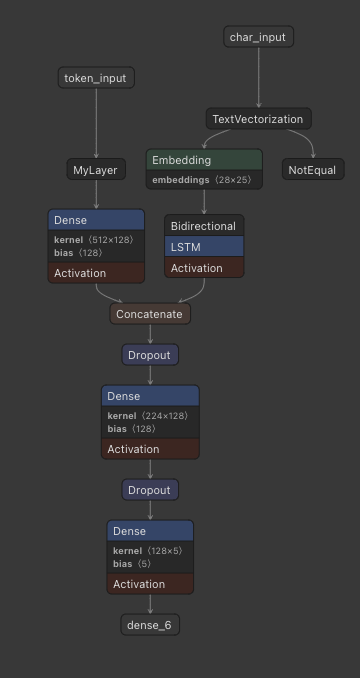

In [89]:
from IPython.display import Image
Image("model_4_architecture.png")